# Data


In [ ]:
# Import Libraries
from google.colab import drive
import zipfile
import os
import librosa
import IPython.display as ipd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import librosa.display
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# mount drive
drive.mount('/content/drive')

# extract files
zip_path = "/content/drive/MyDrive/elec378 sp25 dataset.zip"
extract_path = "/content/elec378_dataset"

# unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

data_dir = "/content/elec378_dataset/elec378 sp25 dataset"

Mounted at /content/drive


In [ ]:
# listening!
# data_dir = "/content/elec378_dataset/elec378 sp25 dataset/elec378 sp25 dataset"
file_path = os.path.join(data_dir, "Angry", os.listdir(os.path.join(data_dir, "Angry"))[0])
audio, sr = librosa.load(file_path)

print("Sample rate:", sr)
print("Audio length (s):", len(audio)/sr)
ipd.Audio(audio, rate=sr)

Sample rate: 22050
Audio length (s): 4.63795918367347


In [ ]:
emotions = ['Happy', 'Suprised', 'Sad', 'Disgusted', 'Fearful', 'Angry', 'Neutral']

durations = []

for emotion in emotions:
    folder_path = os.path.join(data_dir, emotion)
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            path = os.path.join(folder_path, file)
            try:
                y, sr = librosa.load(path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)
                durations.append(duration)
            except Exception as e:
                print(f"Failed to process {file}: {e}")

# Stats
import numpy as np
print(f"Processed {len(durations)} files")
print(f"Average duration: {np.mean(durations):.2f} seconds")
print(f"Min: {np.min(durations):.2f} s, Max: {np.max(durations):.2f} s, Std: {np.std(durations):.2f} s")

Processed 10241 files
Average duration: 2.72 seconds
Min: 1.25 s, Max: 7.14 s, Std: 0.84 s


/content/elec378_dataset/elec378 sp25 dataset/elec378 sp25 dataset/Happy/Happy705.wav


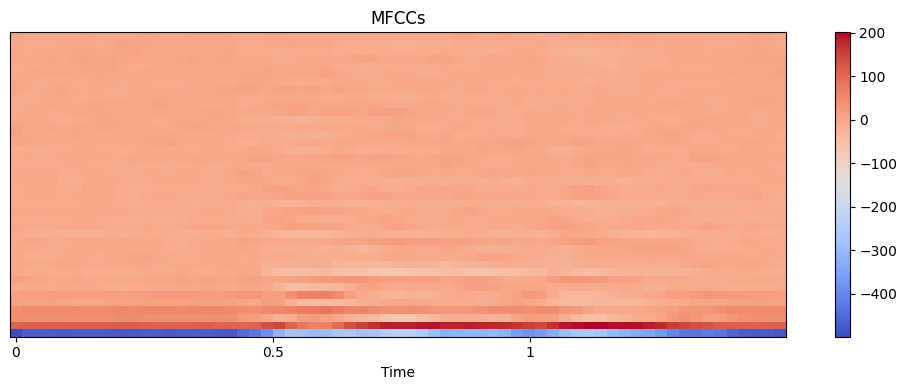

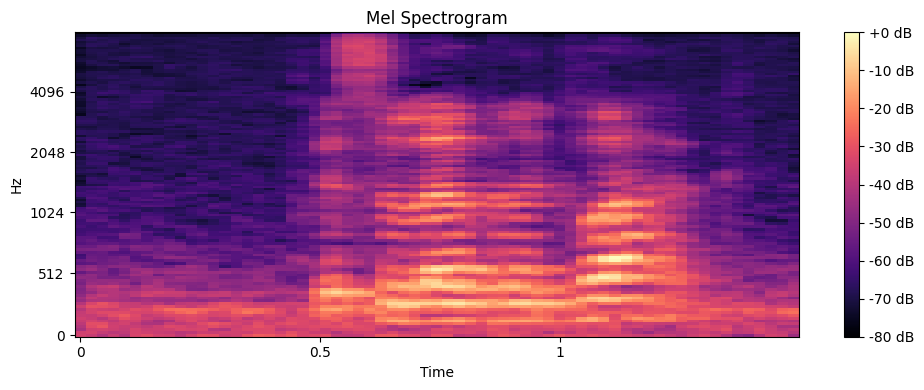

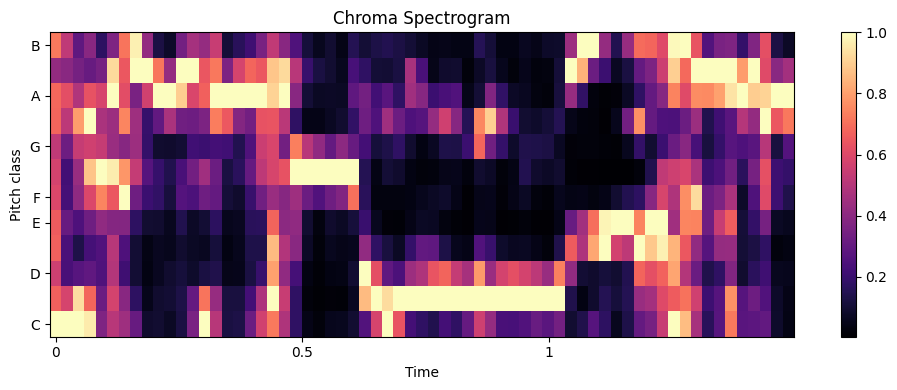

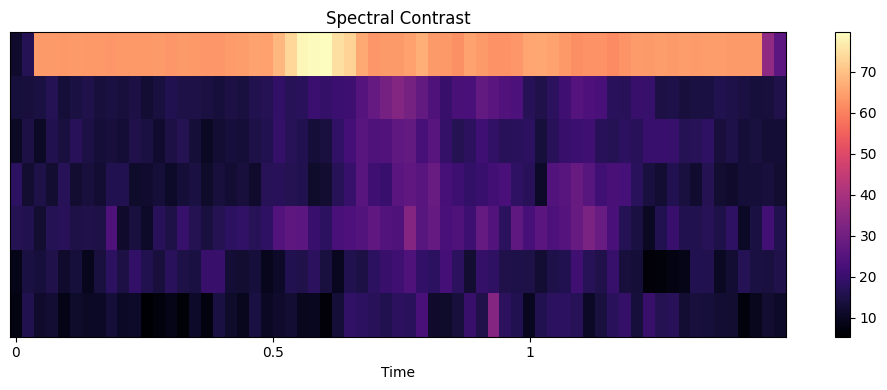

In [ ]:
# Visualizations for different features

# === Load audio (adjust path) ===
file_path = os.path.join(data_dir, "Happy", os.listdir(os.path.join(data_dir, "Happy"))[0])
y, sr = librosa.load(file_path, sr=22050, duration=1.5)

# === 1. MFCC (Timbre / texture)===
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.tight_layout()
plt.savefig("plot_mfcc.png", dpi=300)
plt.show()

# === 1.1 Mel Spectrogram ==
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.savefig("plot_mel_spectrogram.png", dpi=300)
plt.show()

# === 2. Chroma (Pitch class)===
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar()
plt.title("Chroma Spectrogram")
plt.tight_layout()
plt.savefig("plot_chroma.png", dpi=300)
plt.show()

# === 3. Spectral Contrast (Sharpness / noisiness) ===
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(contrast, x_axis='time', sr=sr)
plt.colorbar()
plt.title("Spectral Contrast")
plt.tight_layout()
plt.savefig("plot_contrast.png", dpi=300)
plt.show()

# kNN - Model 1


In [ ]:
# === EXTRACT FEATURES ===
def extract_features(file_name, duration=2):
    '''
    Loads only the first 2 seconds of each .wav file.
    Extracts: 20 MFCCs, 12 Chroma features
    Combines these into a (32, T) matrix,
    then averages over time → ends up with a flat 32-element vector per file.
    '''
    try:
        # Load entire file or up to 2 seconds
        audio, sr = librosa.load(file_name, sr=None, duration=duration)

        # Extract MFCCs + Chroma
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

        # Combine + average over time
        all_features = np.vstack([mfccs, chroma])
        return np.mean(all_features, axis=1)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return None

In [ ]:
emotions = ['Happy', 'Suprised', 'Sad', 'Disgusted', 'Fearful', 'Angry', 'Neutral']
features = []
labels_for_features = []

# === FEATURE EXTRACTION LOOP ===
for emotion in emotions:
    folder_path = os.path.join(data_dir, emotion)
    # use only 10 files per class (for speed)
    for file in os.listdir(folder_path)[:10]:
        if file.endswith(".wav"):
            file_path = os.path.join(folder_path, file)
            feat = extract_features(file_path, duration=2)
            if feat is not None:
                features.append(feat)
                labels_for_features.append(emotion)

In [ ]:
# === KNN ===
X = np.array(features)
y = np.array(labels_for_features)

# Encode labels (e.g., 'Happy' → 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Initialize kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on validation data
y_pred = knn.predict(X_val)

# Evaluate
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.40      1.00      0.57         2
   Disgusted       0.00      0.00      0.00         2
     Fearful       0.00      0.00      0.00         2
       Happy       0.00      0.00      0.00         2
     Neutral       0.00      0.00      0.00         2
         Sad       0.00      0.00      0.00         2
    Suprised       0.25      0.50      0.33         2

    accuracy                           0.21        14
   macro avg       0.09      0.21      0.13        14
weighted avg       0.09      0.21      0.13        14



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# === GENERATE PRED. ON TEST SET ==

# Load and Extract Features from Test Files
test_dir = "/content/elec378_dataset/elec378 sp25 dataset/Test"
test_features = []
test_filenames = []

for file in sorted(os.listdir(test_dir), key=lambda x: int(x.split(".")[0])):
    if file.endswith(".wav"):
        path = os.path.join(test_dir, file)
        feat = extract_features(path, duration=2)
        if feat is not None:
            test_features.append(feat)
            test_filenames.append(file)

# Predict on Test Set
X_test = np.array(test_features)
test_preds_encoded = knn.predict(X_test)
# Decode back to original emotion labels (e.g., 'Happy', 'Sad')
test_preds = label_encoder.inverse_transform(test_preds_encoded)

# Export to Submission as .csv
submission_df = pd.DataFrame({
    "filename": [f"{i}.wav" for i in range(1, len(test_preds) + 1)],
    "emotion": test_preds})
submission_df.to_csv("first_knn.csv", index=False)

**Initial Model Results** \
Validation Data Accuracy: 0.21 \
Private Score: 0.27521 \
Public score: 0.28482

# kNN- MFCC Only model


In [ ]:
from sklearn.metrics import accuracy_score

data_dir = "/content/elec378_dataset/elec378 sp25 dataset"
emotions = ['Happy', 'Suprised', 'Sad', 'Disgusted', 'Fearful', 'Angry', 'Neutral']
sr = 22050
n_mfcc = 40
durations_to_test = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]

def extract_mfcc_only(path, clip_duration, sr=22050, n_mfcc=40):
    try:
        y, sr = librosa.load(path, sr=sr)
        if len(y) < int(clip_duration * sr):
            pad_len = int(clip_duration * sr) - len(y)
            y = np.pad(y, (0, pad_len))
        clip_len = int(clip_duration * sr)
        num_clips = max(1, len(y) // clip_len)
        clip_features = []

        for i in range(num_clips):
            clip = y[i*clip_len : (i+1)*clip_len]
            if len(clip) < clip_len:
                clip = np.pad(clip, (0, clip_len - len(clip)))
            mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=n_mfcc)
            vector = np.mean(mfcc, axis=1)
            clip_features.append(vector)
        return clip_features
    except Exception as e:
        return None

# Run test loop
for clip_duration in durations_to_test:
    features = []
    labels = []

    for emotion in emotions:
        folder_path = os.path.join(data_dir, emotion)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                path = os.path.join(folder_path, file)
                feats = extract_mfcc_only(path, clip_duration)
                if feats:
                    features.extend(feats)
                    labels.extend([emotion] * len(feats))

    if len(features) == 0:
        print(f"No data for duration {clip_duration}")
        continue

    X = np.array(features)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"clip_duration = {clip_duration:.2f} → Val Accuracy: {acc:.4f}")


clip_duration = 0.50 → Val Accuracy: 0.4541
clip_duration = 1.50 → Val Accuracy: 0.5309
clip_duration = 2.50 → Val Accuracy: 0.5681
clip_duration = 3.50 → Val Accuracy: 0.5642
clip_duration = 4.50 → Val Accuracy: 0.5632
clip_duration = 5.50 → Val Accuracy: 0.5661
clip_duration = 6.50 → Val Accuracy: 0.5637


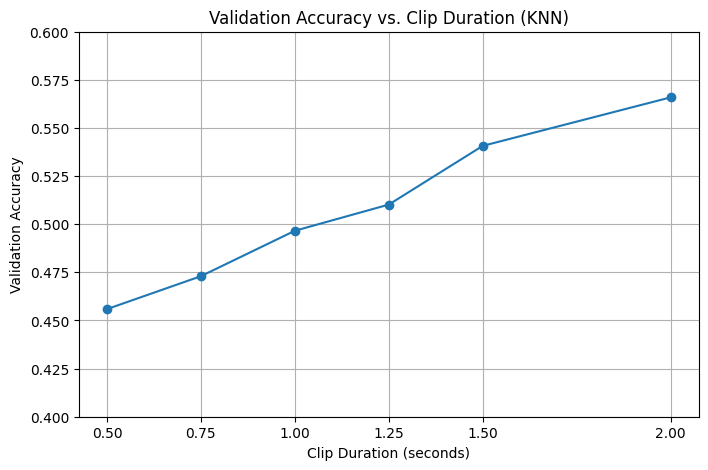

In [ ]:
# Results
clip_durations = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
accuracies = [0.4559, 0.4730, 0.4966, 0.5102, 0.5407, 0.5659]

plt.figure(figsize=(8, 5))
plt.plot(clip_durations, accuracies, marker='o', linestyle='-')
plt.title("Validation Accuracy vs. Clip Duration (KNN)")
plt.xlabel("Clip Duration (seconds)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.xticks(clip_durations)
plt.ylim(0.4, 0.6)
plt.savefig("knn_clip_duration_vs_accuracy.png", dpi=300)
plt.show()

Model using 7.0 second clips (no slicing) but keeps everything else:

In [ ]:
# === PARAMETERS ===
data_dir = "/content/elec378_dataset/elec378 sp25 dataset"
emotions = ['Happy', 'Suprised', 'Sad', 'Disgusted', 'Fearful', 'Angry', 'Neutral']
clip_duration = 7.0
sr = 22050
n_mfcc = 40

features = []
labels = []

def extract_mfcc_clip(path, clip_duration=7.0, sr=22050, n_mfcc=40):# try to load up to 7 seconds
    try:
        y, sr = librosa.load(path, sr=sr, duration=clip_duration)
        if len(y) < int(clip_duration * sr):
            y = np.pad(y, (0, int(clip_duration * sr) - len(y)))
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfcc, axis=1)
    except:
        return None

# === EXTRACT FEATURES ===
for emotion in emotions:
    folder_path = os.path.join(data_dir, emotion)
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            path = os.path.join(folder_path, file)
            feat = extract_mfcc_clip(path, clip_duration)
            if feat is not None:
                features.append(feat)
                labels.append(emotion)

X = np.array(features)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

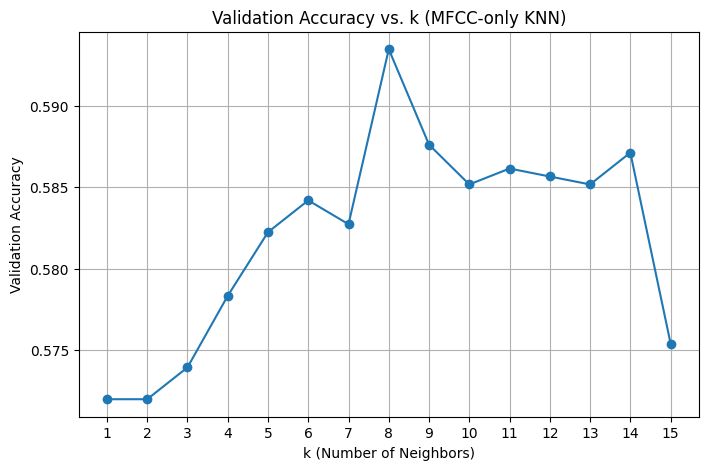

In [ ]:
ks = list(range(1, 16))
accuracies = []

for k in ks:
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='cosine')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(ks, accuracies, marker='o')
plt.title("Validation Accuracy vs. k (MFCC-only KNN)")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Validation Accuracy")
plt.xticks(ks)
plt.grid(True)
plt.savefig("knn_mfcc_only_k_vs_accuracy.png", dpi=300)
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# === KNN MODEL ===
knn = KNeighborsClassifier(n_neighbors=8, weights='distance', metric='cosine')
knn.fit(X_train, y_train)

# === VALIDATION RESULTS ===
y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       Angry       0.70      0.72      0.71       347
   Disgusted       0.55      0.47      0.51       298
     Fearful       0.52      0.50      0.51       328
       Happy       0.68      0.52      0.59       347
     Neutral       0.58      0.54      0.56       287
         Sad       0.50      0.69      0.58       347
    Suprised       0.79      0.87      0.83        95

    accuracy                           0.59      2049
   macro avg       0.62      0.62      0.61      2049
weighted avg       0.60      0.59      0.59      2049



In [ ]:
test_dir = "/content/elec378_dataset/elec378 sp25 dataset/Test"
test_preds = []
test_filenames = []

# One-Clip per file + majority vote if needed
for file in sorted(os.listdir(test_dir)):
    if file.endswith(".wav"):
        path = os.path.join(test_dir, file)
        feat = extract_mfcc_clip(path, clip_duration)
        if feat is not None:
            feat_scaled = scaler.transform([feat])
            pred = knn.predict(feat_scaled)[0]
        else:
            pred = np.bincount(y_train).argmax()  # fallback
        test_preds.append(pred)
        test_filenames.append(file)

In [ ]:
# Decode predictions to emotion labels
test_emotions = label_encoder.inverse_transform(test_preds)

In [ ]:
# Save to CSV
submission = pd.DataFrame({
    "filename": test_filenames,
    "emotion": test_emotions})

In [ ]:
submission.shape

(2557, 2)

In [ ]:
submission.to_csv("mfcc_7sec_k5.csv", index=False)

# PCA


Use PCA to reduce to 20 components:

In [ ]:
# === PCA ===
# reduce to 20 components
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# train with best k
best_k = 5  # or your tuned value
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_pca, y_train)

# accuracy
y_pred_pca = knn.predict(X_val_pca)
print(classification_report(y_val, y_pred_pca, target_names=label_encoder.classes_))


test_preds = []
test_filenames = []

for file in sorted(os.listdir(test_dir)):
    if file.endswith(".wav"):
        path = os.path.join(test_dir, file)
        feats = extract_mfcc_only(path, clip_duration = 2)
        if feats and len(feats) > 0:
            feats_scaled = scaler.transform(feats)
            feats_pca = pca.transform(feats_scaled)
            preds = knn.predict(feats_pca)
            vote = np.bincount(preds).argmax()
        else:
            vote = np.bincount(y_train).argmax()  # fallback
        test_preds.append(vote)
        test_filenames.append(file)

test_emotions = label_encoder.inverse_transform(test_preds)
submission_df = pd.DataFrame({
    "filename": test_filenames,
    "emotion": test_emotions
})
submission_df.to_csv("knn_pca_3.csv", index=False)

              precision    recall  f1-score   support

       Angry       0.63      0.70      0.66       347
   Disgusted       0.49      0.44      0.47       298
     Fearful       0.44      0.48      0.46       328
       Happy       0.58      0.54      0.56       347
     Neutral       0.51      0.55      0.53       287
         Sad       0.57      0.52      0.55       347
    Suprised       0.80      0.84      0.82        95

    accuracy                           0.55      2049
   macro avg       0.58      0.58      0.58      2049
weighted avg       0.55      0.55      0.55      2049



# Full Feature Model

NO PCA!! But full features

In [ ]:
def extract_full_features(path, sr=22050, n_mfcc=40):
    try:
        y, sr = librosa.load(path, sr=sr)
        if len(y) < sr * 7.0:
            y = np.pad(y, (0, int(sr * 7.0) - len(y)))
        y = y[:int(sr * 7.0)]  # Ensure consistent length
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        flatness = librosa.feature.spectral_flatness(y=y)
        vector = np.concatenate([
            np.mean(mfcc, axis=1),
            np.mean(chroma, axis=1),
            np.mean(contrast, axis=1),
            np.mean(flatness, axis=1)
        ])
        return vector
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

In [ ]:
features = []
labels = []

for emotion in emotions:
    folder_path = os.path.join(data_dir, emotion)
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            path = os.path.join(folder_path, file)
            feats = extract_full_features(path)
            if feats is not None:
                features.append(feats)
                labels.append(emotion)

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
X = np.array(features)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Angry       0.72      0.71      0.72       347
   Disgusted       0.53      0.43      0.48       298
     Fearful       0.52      0.52      0.52       328
       Happy       0.63      0.56      0.59       347
     Neutral       0.57      0.53      0.55       287
         Sad       0.51      0.68      0.58       347
    Suprised       0.84      0.88      0.86        95

    accuracy                           0.59      2049
   macro avg       0.62      0.62      0.61      2049
weighted avg       0.59      0.59      0.59      2049



In [ ]:
test_preds = []
test_filenames = []

# Fallback label in case feature extraction fails
fallback_label = np.bincount(y_train).argmax()

for file in sorted(os.listdir(test_dir)):
    if file.endswith(".wav"):
        path = os.path.join(test_dir, file)
        feats = extract_full_features(path)
        if feats is not None:
            feats_scaled = scaler.transform([feats])  # 2D shape: (1, 60)
            pred = knn.predict(feats_scaled)[0]
        else:
            pred = fallback_label  # fallback to most common class
        test_preds.append(pred)
        test_filenames.append(file)

In [ ]:
# Save to csv
test_emotions = label_encoder.inverse_transform(test_preds)
submission_df = pd.DataFrame({
    "filename": test_filenames,
    "emotion": test_emotions
})
submission_df.shape

(2557, 2)

In [ ]:
submission_df.to_csv("fullfeat_7s_cos_k5.csv", index=False)

# Testing different k for Full Feature model

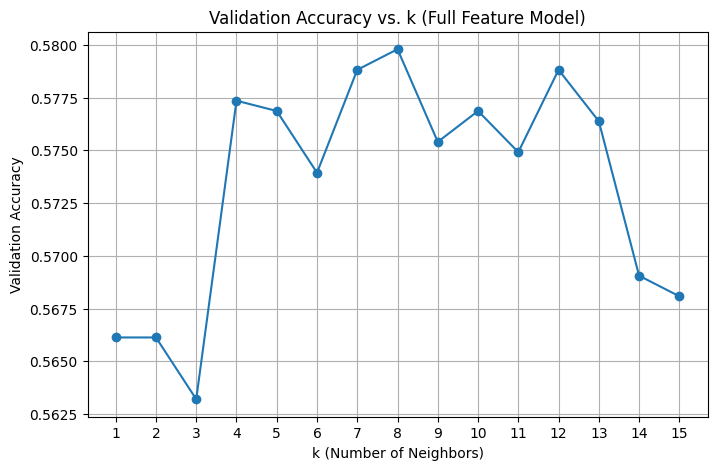

In [ ]:
ks = list(range(1, 16))
accuracies = []

for k in ks:
    # Re-split the same data for consistency
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )

    # Train KNN with current k
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='cosine')
    knn.fit(X_train, y_train)

    # Predict & score
    y_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ks, accuracies, marker='o')
plt.title("Validation Accuracy vs. k (Full Feature Model)")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.xticks(ks)
plt.show()


Tuning k for MFCC-only model:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8, weights='distance', metric='cosine')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Angry       0.74      0.67      0.70       347
   Disgusted       0.56      0.44      0.50       298
     Fearful       0.53      0.48      0.50       328
       Happy       0.56      0.55      0.55       347
     Neutral       0.50      0.63      0.56       287
         Sad       0.54      0.60      0.57       347
    Suprised       0.74      0.92      0.82        95

    accuracy                           0.58      2049
   macro avg       0.60      0.61      0.60      2049
weighted avg       0.58      0.58      0.58      2049



In [ ]:
test_preds = []
test_filenames = []

# Fallback label in case feature extraction fails
fallback_label = np.bincount(y_train).argmax()

for file in sorted(os.listdir(test_dir)):
    if file.endswith(".wav"):
        path = os.path.join(test_dir, file)
        feats = extract_full_features(path)
        if feats is not None:
            feats_scaled = scaler.transform([feats])  # 2D shape: (1, 60)
            pred = knn.predict(feats_scaled)[0]
        else:
            pred = fallback_label  # fallback to most common class
        test_preds.append(pred)
        test_filenames.append(file)

In [ ]:
# Save to csv
test_emotions = label_encoder.inverse_transform(test_preds)
submission_df = pd.DataFrame({
    "filename": test_filenames,
    "emotion": test_emotions
})
submission_df.to_csv("full_euc_k8_7s.csv", index=False)